In [66]:
import sys
sys.path.append('../..')
#sys.path.append( '/home/cactuskid13/miniconda3/pkgs/')
print(sys.path)

['/scratch/dmoi/projects/HogProf/pyprofiler/notebooks', '/scratch/dmoi/condaenvs/ML2/lib/python39.zip', '/scratch/dmoi/condaenvs/ML2/lib/python3.9', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/lib-dynload', '', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages', '/scratch/dmoi/software/pyham', '/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/IPython/extensions', '/users/dmoi/.ipython', '../..', '../..']


In [67]:
import torch

In [68]:
from pyprofiler.utils import hashutils
import ete3
import random
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.utils.hashutils as hashutils
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pyprofiler.profiler as profiler
import pandas as pd
import itertools
import redis
##to get the mapping of oma hogs to cogs to interactions in specific species I used dask distributed and a redis server
#you may need to get these up and running for you own cluster configuration before this notebook will work for you
import dask
import warnings


from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


import scipy
from dask import dataframe as dd
import pickle
from bloom_filter2 import BloomFilter
from sklearn.model_selection import train_test_split


In [69]:
#lets load a compiled db containing the OMA root HOGs into a profiler oject 
p = profiler.Profiler(lshforestpath = '/scratch/dmoi/datasets/all/newlshforest.pkl' , hashes_h5='/scratch/dmoi/datasets/birds/all/hashes.h5' , mat_path= None, oma = '/scratch/dmoi/datasets/OMA/apr2021/OmaServer.h5', tar= None , nsamples = 256 , mastertree = '/scratch/dmoi/datasets/birds/all_test_master_tree.pkl')

loading lsh
indexing lsh


/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/tables/leaf.py:367: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


3508
DONE


In [70]:
def grabHog(ID, verbose = True):
    try:
        entry = p.db_obj.entry_by_entry_nr(p.db_obj.id_resolver.resolve(ID))
        return entry[4].decode() , entry
    except:
        return np.nan,np.nan
#map to OMA HOGs

In [71]:
humap = '/scratch/dmoi/datasets/humap_PPI/humap2_ppis_ACC_20200821.pairsWprob'
calc_humap = False
if calc_humap == True:
    #load humap data
    humap_df = pd.read_table(humap, header = None)
    print(humap_df)
    humap_df = humap_df[humap_df[2] > .75 ]
    mapper = set( list(humap_df[1]) + list(humap_df[0]) )
    mapper = { protid: grabHog(protid) for protid in mapper }
    humap_df['hog1'] = humap_df[1].map(mapper)
    humap_df['hog2'] = humap_df[0].map(mapper)
    humap_df['hogid_1'] = humap_df['hog1'].map(lambda x:x[0])
    humap_df['hogid_2'] = humap_df['hog2'].map(lambda x:x[0])
    humap_df = humap_df.dropna()
    humap_df['fam1'] = humap_df['hog1'].map( lambda x :   p.hogid2fam(x[1]) )
    humap_df['fam2'] = humap_df['hog2'].map( lambda x :   p.hogid2fam(x[1]) ) 
    humap_df = humap_df.dropna()
    humap_df.fam1 = humap_df.fam1.map(int)
    humap_df.fam2 = humap_df.fam2.map(int)
    print(len(humap_df))
    humap_df.to_csv(humap+'hogmapped.csv')
else:
    humap_df = pd.read_csv(humap+'hogmapped.csv')

In [72]:
humap_pairs = humap_df

In [73]:
profiles = {}
calc_hogs_humap = False
if calc_hogs_humap == True:
    allhogs = set([])
    allhogs = allhogs.union( set(humap_df.fam1.unique() ) )
    allhogs = allhogs.union( set(humap_df.fam2.unique() ) )
    print(len(allhogs))
    for fam in allhogs:
        print(fam)
        try:
            prof = p.return_profile_OTF(fam)
        except:
            print('err', fam)
        print(prof)
        profiles.update(prof)

In [74]:
save_Hogs_humap = False
if save_Hogs_humap == True:
    with open(humap + 'gold_standard_profiles.pkl' , 'wb') as profiles_out:
        profiles_out.write(pickle.dumps(profiles))

In [75]:
with open(humap + 'gold_standard_profiles.pkl' , 'rb') as profiles_out:
    humap_profiles = pickle.loads(profiles_out.read())

In [76]:
humap_df = pd.DataFrame.from_dict(humap_profiles , orient = 'index')
print(humap_df.head())

                                                      mat  \
524288  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
516097  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
516099  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
786438  [[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,...   
573452  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                     tree  
524288  (((\n--7757)), ((\n--7764)), ((\n--9597)), ((\...  
516097  (((\n--9597)), ((\n--9598)), ((\n--9606)), ((\...  
516099  (((\n--9597)), ((\n--9598)), ((\n--9606)), ((\...  
786438  (((\n--868595)), ((\n--349161)), ((\n--696281)...  
573452  (((\n--120017)), ((\n--237631)), ((\n--1230383...  


In [77]:
#################begin building the string dataset ###################################

In [78]:
filter_coglinks = False
if filter_coglinks == True:
    from collections import Counter
    coglink_df = dd.read_csv('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt', blocksize=25e6 , header = 0, sep = ' ')
    print(coglink_df)
    print(coglink_df.columns)
    dropcols = [ 'cooccurence', 'combined_score' ]
    coglink_df = coglink_df.drop(columns = dropcols)
    coglink_df['score'] = coglink_df.coexpression + coglink_df.experimental +coglink_df.database+ coglink_df.textmining
    #these cutoffs ere found below using jaccard and AUC
    coglink_df= coglink_df[coglink_df.score>1000]
    coglink_df= coglink_df[coglink_df.textmining>500]

    coglink_df = coglink_df.compute()
    
    coglink_count = Counter(list(coglink_df.group1)+list(coglink_df.group2))
    coglink_df['count1']= coglink_df.group1.map(coglink_count)
    coglink_df['count2']= coglink_df.group2.map(coglink_count)
    #filter input set
    #coglink_df = coglink_df[coglink_df.count1 > 50 ]
    #coglink_df = coglink_df[coglink_df.count2 > 50 ]
    
    print(coglink_df.head() , len(coglink_df))

In [79]:
#map the interacting cogs to the proteins
compute_grabcogs = False
if compute_grabcogs == True:
    grabcogs = set( list(coglink_df.group1.unique()) + list(coglink_df.group2.unique()) )
    grabcogs= list(grabcogs)
    COGmapings_df = dd.read_csv('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt', blocksize=25e6 , header = 0, sep = '\t')
    COGmapings_df = COGmapings_df.set_index('orthologous_group')
    COGmapings_df.astype(str)
    COGmapings_df['##protein'].map( lambda x : x.strip() )
    COGmapings_df['species'] = COGmapings_df['##protein'].map( lambda x : x.split('.')[0] )
    COGmapings_df['COG'] = COGmapings_df.index
    COGmapings_df = COGmapings_df.loc[grabcogs]
    COGmapings_df = COGmapings_df.compute()
    print(COGmapings_df.head())

In [80]:
#only take the proteins in our cogs of interest
if compute_grabcogs == True:
    grabprots =list(COGmapings_df['##protein'].unique())
    print(len(grabprots))
    with open('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt' + '.grabcogs.txt', 'w') as protsout:
        protsout.write(''.join([ p + '\n' for p in grabcogs ]) )
    with open('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt' + '.grabprots.txt' , 'w') as protsout:
        protsout.write(''.join([ p + '\n' for p in grabprots ]) )
else:
    with open('/scratch/dmoi/datasets/STRING/COG.links.detailed.v11.5.txt' + '.grabcogs.txt', 'r') as protsout:
        grabcogs = [ cog for cog in protsout.readlines()]
    with open('/scratch/dmoi/datasets/STRING/COG.mappings.v11.5.txt' + '.grabprots.txt' , 'r') as protsout:
        grabprots = [ prot for prot in protsout.readlines()]

In [83]:
calc_mappers = False
rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
if calc_mappers == True:
    count = 0
    for i,r in COGmapings_df.iterrows():
        rdb.set(r['##protein'], i)
        count+=1
        if count < 10:
            print(i+'\n',r)
        if count%1000000==0:
            print(count/len(COGmapings_df))

In [84]:
#test redis retreival of cogs
rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
print([ (grabprots[i].strip(),rdb.get( grabprots[i])) for i in range(10) ] )

ConnectionError: Error 111 connecting to 10.202.12.174:6379. Connection refused.

In [85]:
maphogs = False
if maphogs == True:
    #mapping each string cog to an oma hog by selecting a member of the cog
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    hogmap = {}
    for i,prot in enumerate(grabprots):
        if i % 100000 == 0 :
            print(i/len(grabprots))
        cog = rdb.get(prot)
        if cog not in hogmap:
            mapped =  grabHog(prot)
            #retry until something maps
            if mapped[0] != np.nan and type(mapped[0]) == str :
                if len(mapped[0])>1 :
                    hogmap[cog] = mapped
    with open('stringhogmap.pkl' , 'wb')as hogmapout:
        hogmapout.write(pickle.dumps(hogmap))
else:
    with open('stringhogmap.pkl' , 'rb')as hogmapout:
        hogmap = pickle.loads(hogmapout.read())


In [86]:
print(len(hogmap))
for i, key in enumerate(hogmap):
    if i < 10:
        print(key, hogmap[key])

12761
b'COG0022' ('HOG:A0772469', (1134780, 359776777, 338, 36877, b'HOG:A0772469', b'A', 136963, 137976, -1, 0, b'Q9K3H1', 1080465110, 1015, b'6161cbb7b6aed10547b7c95555c1c63a', 60128051, 322, b'', -1, -1))
b'COG1071' ('HOG:A0780700.10b.7b', (3753108, 1179251817, 734, 598427, b'HOG:A0780700.10b.7b', b'A', 2952449, 2954650, -1, 0, b'F4GWD5', 3541508558, 2203, b'0eaa8538e27a234812d4b19c67f1f560', 234217123, 43, b'', -1, -1))
b'COG0508' ('HOG:A0757171.22b.54b.29a', (3288989, 1034223672, 469, 598421, b'HOG:A0757171.22b.54b.29a', b'A', 1363913, 1365319, 1, 0, b'G4R8Y9', 3105960004, 1408, b'3b9ecc15f5881cc16928ba7e6a656fe6', 205095449, 48, b'', -1, -1))
b'COG0462' ('HOG:A0780700', (14151364, 5935651032, 846, 598427, b'HOG:A0780700', b'supercontig_To_g48347', 2246, 4990, -1, 0, b'K0RIS8', 17821104459, 2539, b'8f2ac7bfb36b9ffe82ad5d8dc2410bae', 696068665, 22, b'', -1, -1))
b'COG4886' ('HOG:A0779810.2c.30a.12a.2a', (16107232, 6695185680, 411, 598444, b'HOG:A0779810.2c.30a.12a.2a', b'1', 160094

In [87]:
#add the HOGs to the COGdf
#grab the corresponding profiles
compile_final_cogdf = False
if compile_final_cogdf == True:
    print(len(coglink_df))
    try:
        coglink_df.group1  = coglink_df.group1.map( lambda x : x.encode())
        coglink_df.group2  = coglink_df.group2.map( lambda x : x.encode())
    except:
        pass
    coglink_df['hog1'] = coglink_df.group1.map(hogmap)
    coglink_df['hog2'] = coglink_df.group2.map(hogmap)
    coglink_df=coglink_df.dropna()
    print(len(coglink_df))
    print(coglink_df.head())
    coglink_df['hogid_1'] = coglink_df['hog1'].map(lambda x:x[0])
    coglink_df['hogid_2'] = coglink_df['hog2'].map(lambda x:x[0])
    coglink_df['fam1'] = coglink_df['hog1'].map( lambda x :   p.hogid2fam(x[1]) )
    coglink_df['fam2'] = coglink_df['hog2'].map( lambda x :   p.hogid2fam(x[1]) ) 
    coglink_df.fam1 = coglink_df.fam1.map(int)
    coglink_df.fam2 = coglink_df.fam2.map(int)
    stringHOGs = set(coglink_df.fam1.unique()).union(set(coglink_df.fam2.unique()))
    print(len(stringHOGs))
    print(coglink_df)
    coglink_df.to_csv('STRINGCOGS2OMAHOGS.csv')
else:
    coglink_df = pd.read_csv('STRINGCOGS2OMAHOGS.csv')

In [88]:
stringPairs = coglink_df

In [89]:
#derive explicit profiles for our hogs of interest in string
calc_hogs_string = False
stringprofiles = {}
if calc_hogs_string == True:
    print('profiles to calclulate',len(stringHOGs))
    for i,fam in enumerate(stringHOGs):
        if i % 100 ==0:
            print(i)
        try:
            prof = p.return_profile_OTF(fam)
            stringprofiles.update(prof)
        except:
            print('err',fam)

In [90]:
if calc_hogs_string == True:
    with open('/scratch/dmoi/datasets/STRING/' + 'gold_standard_profiles.pkl' , 'wb') as profiles_out:
        profiles_out.write(pickle.dumps(stringprofiles))

In [91]:
with open('/scratch/dmoi/datasets/STRING/' + 'gold_standard_profiles.pkl' , 'rb' )as profiles_out:
    stringprofiles = pickle.loads(profiles_out.read())

In [92]:
string_df = pd.DataFrame.from_dict(stringprofiles , orient='index')

In [93]:
#make the profiles for this small set of HOGs
for i, key in enumerate(stringprofiles):
    if i < 10:
        print(key,stringprofiles[key])

786432 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f00ba6ee94)}
786433 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f01a1da2b2)}
524294 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f02062a1d6)}
786440 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f020625564)}
524299 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f0205f5928)}
786448 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f0205effb2)}
786449 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f0205c1e76)}
786450 {'mat': array([[1., 1., 1., ..., 0., 0., 0.]]), 'tree': Tree node '131567' (0x7f020593e3a)}
131092 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '1648030' (0x7f02055c8fa)}
524309 {'mat': array([[0., 0., 0., ..., 0., 0., 0.]]), 'tree': Tree node '7742' (0x7f02055de10)}


In [94]:
#now we have profiles for all HUMAP and COG interactions
#String has interactions from each COG in different species.
#We need a way to check for the presence of interaction within a species for a COG
#for this we will create a bloom filter with all the interactions between our cogs

calc_filter = False

In [95]:
if calc_filter == True:
    from dask.distributed import fire_and_forget
    from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
    from dask_jobqueue import SLURMCluster
    from dask.distributed import  utils_perf
    from dask.distributed import Client, LocalCluster
    import dask
    import redis
    from bloom_filter2 import BloomFilter
    import lzma
    from dask import dataframe as dd
    distributed = True

In [96]:
if calc_filter == True:
    if distributed == True:
        NCORE = 4
        print('deploying cluster')
        cluster = SLURMCluster(
            walltime='4:00:00',
            n_workers = NCORE,
            cores=NCORE,
            processes = NCORE,
            interface='ib0',
            memory="120GB",
            env_extra=[
            'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
            'conda activate ML2'
            ],
            #scheduler_options={'interface': 'ens2f0' },
            #if gpu node
            scheduler_options={'interface': 'ens3f0' },
            #extra=["--lifetime", "3h55m", "--lifetime-stagger", "4m"]
        )
        print(cluster.job_script())

    else:
        cluster = LocalCluster()
        client = Client(cluster)

In [97]:
if calc_filter == True:
    if distributed == True:
        print(cluster)
        cluster.scale(jobs = 100)
        print(cluster.dashboard_link)
        client = Client(cluster , timeout='450s' , set_as_default=True )

In [98]:
#find which species each of the cogs has an interaction in
if calc_filter == True:
    
    #link_df = dd.read_csv('/scratch/dmoi/datasets/STRING/protein.physical.links.detailed.v11.5.txt', blocksize=100e6 , header = 0, sep = ' ')
    link_df = dd.read_csv('/scratch/dmoi/datasets/STRING/protein.links.full.v11.5.txt',  blocksize=75e6 , header = 0, sep = ' ')
    print(link_df)
    

In [99]:
#compute bloom filters for protein pairs
@dask.delayed
def mapcogs(df ):
    rdb = redis.Redis(host='10.202.12.174', port=6379, db=0)
    if type( df ) == tuple:
        df = df[0]
    protlist1 = list(df.protein1.map(lambda x:str(x).strip()))
    protlist2 = list(df.protein2.map(lambda x:str(x).strip()))
    protlist = list(set(protlist1+protlist2))
    data = rdb.mget(protlist)
    mapper = dict(zip(protlist, data) )
    df['COG1'] = df.protein1.map(mapper)
    df['COG2'] = df.protein2.map(mapper)
    df = df.dropna()
    df['COG1'] = df.COG1.map(lambda x:str(x).replace("b",'').replace("'",'').strip() )
    df['COG2'] = df.COG2.map(lambda x:str(x).replace("b",'').replace("'",'').strip() )
    df['species'] = df.protein1.map(lambda x:x.split('.')[0])
    df['coglinks'] = df.COG1 + '_' + df.COG2 + '_' + df.species
    ret = set(df.coglinks.unique())
    return ret
@dask.delayed
def return_filter(coglinks, verbose = True):
    if type( coglinks ) == tuple:
        coglinks = coglinks[0]
    b=BloomFilter(max_elements=10**8, error_rate=0.001 ,start_fresh = True)
    for p in coglinks:
        b.add( p )
    retlen = len(coglinks)
    return   b , retlen

@dask.delayed
def sumfilter(f1,f2, total ):
    if type( f1 ) == tuple:
        f1 = f1[0]
    if type( f2 ) == tuple:
        f2 = f2[0]
    f3 = f1.__ior__(f2)
    return f3 , total

In [100]:
def treesum(totalfilter):
    print(len(totalfilter))
    while len(totalfilter)>1:
        next_round= []
        for i in range(0,len(totalfilter),2):
            if i+1 < len(totalfilter):
                next_round.append( sumfilter( totalfilter[i][0] , totalfilter[i+1][0] , totalfilter[i][1]+totalfilter[i+1][1]  ) )
        if len(totalfilter) % 2 !=0:
            next_round.append(totalfilter[-1])
        totalfilter = next_round
        print(len(totalfilter))
    return totalfilter

if calc_filter == True:
    b=BloomFilter(max_elements=10**8, error_rate=0.001 ,start_fresh = True)
    partitions  = link_df.to_delayed()
    print('map cogs')
    res1 = [ mapcogs(p) for p in partitions ]
    print('done')
    print('make filters')
    res2 = [ return_filter(p) for p in res1 ]
    finals =[]
    for chunk in range(int(len(res2)/1024)+1):
        print(chunk*1024)
        res3 = res2[chunk*1024:(chunk+1)*1024]
        res4 = treesum(res3)
        res4 = dask.compute(res4)
        print(res4)
        finals.append(res4[0])

    with open('bloomfinal_big.pkl' , 'wb' ) as finalout:
        finalout.write(pickle.dumps(finals))

In [101]:
if calc_filter == True:
    with open('bloomfinal_big.pkl' , 'wb' ) as finalout:
        finalout.write(pickle.dumps(finals))


In [102]:
with open('bloomfinal_big.pkl' , 'rb' ) as finalout:
    resfinal = pickle.loads(finalout.read()) 
print(resfinal)

[[(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 88441700)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 104024529)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 139867517)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 148873261)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 79242584)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 84543441)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 79065634)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 87236883)], [(BloomFilter(ideal_num_elements_n=100000000, error_rate_p=0.001000, num_bits_m=1437758757), 119141778)], [(BloomFilter(ideal_num_elements_n=100000000, erro

In [103]:
def check_filters(element,filters):
    for f in filters:
        if element in f[0][0]:
            return True
    return False
import functools
bfilter = functools.partial(check_filters , filters= resfinal)
print(bfilter('COG1756_COG0088_4113'))
print(bfilter('crap'))

True
False


In [104]:
#lets try it out. we should be able to find in which species two cogs interact with the bloom filter
cog1='COG0088'
cog2 ='COG1756'
coglink = cog1 + '_' + cog2 + '_'

In [105]:
taxmapper = 'string2oma_specmap.pkl'
calc_taxmapper = True
if calc_taxmapper == True:
     with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #compare lineages to get the closest
        from ete3 import NCBITaxa
        ncbi = NCBITaxa()
        #map profiler leaves to closest leaf in string
        strings_species = '/scratch/dmoi/datasets/STRING/species.v11.5.txt'
        string_specdata = pd.read_table(strings_species)
        print(string_specdata)
        stringset = set([ str(tax) for tax in list(string_specdata['#taxon_id']) ]) 
        omaset =  set([ spec.name  for spec in p.tree.get_leaves()])
        print('omaset',len(omaset))
        print('stringset',len(stringset))
        shared_leaves = omaset.intersection(stringset)
        missing_leaves = omaset - stringset
        #these are oma leaves not in string...we can map to the closest string species.
        string_missing = stringset - omaset
        omalineages = {tax: set(ncbi.get_lineage(int(tax))) for tax in missing_leaves}
        stringlineages = {tax: set(ncbi.get_lineage(int(tax))) for tax in string_missing}
        string2oma={}
        print('done lineages')
        for i,tax in enumerate(stringlineages):
            #find the closest
            shared = { tax_oma: len(stringlineages[tax].intersection(omalineages[tax_oma]))/len(omalineages[tax_oma]) for tax_oma in omalineages } 

            string2oma[tax] = max(shared, key=shared.get)
            if i %1000 == 0:
                print(i/ len(stringlineages) )
        with open(taxmapper, 'wb') as taxmapper:
            taxmapper.write(pickle.dumps(string2oma))
else:
    with open(taxmapper, 'rb') as taxmapper:
        string2oma= pickle.loads(taxmapper.read())

       #taxon_id STRING_type            STRING_name_compact  \
0             23      mapped         Shewanella colwelliana   
1             48      mapped             Archangium gephyra   
2             52      mapped          Chondromyces crocatus   
3             54      mapped            Nannocystis exedens   
4             69      mapped         Lysobacter enzymogenes   
...          ...         ...                            ...   
14089    2518989      mapped  Halieaceae bacterium IMCC3088   
14090    2562755      mapped    Metschnikowia sp. JCM 33374   
14091    2587831      mapped   Terrapene carolina triunguis   
14092    2594813      mapped          Fusarium fasciculatum   
14093    2656787      mapped    Venustampulla echinocandica   

                  official_name_NCBI      domain  
0             Shewanella colwelliana    Bacteria  
1                 Archangium gephyra    Bacteria  
2              Chondromyces crocatus    Bacteria  
3                Nannocystis exedens   

In [106]:
print(len(set(string2oma.keys())))
print(len(set(string2oma.values())))

12320
256


In [107]:
#test out to find the species for a cog pair
species = [ spec.name  for spec in p.tree.get_leaves()] + list(string2oma.keys())
species = set(species)
print(len(species))
coglinks_species = [ coglink+spec for spec in species ]
checklinks = [ bfilter( spec) for spec in coglinks_species ]
species_set = [s for s in species]
links = [ l for l,c in list(zip(coglinks_species,checklinks))  if c== True  ]
species_set = [ s for s,c in list(zip(species_set,checklinks))  if c== True  ]
species_set = set([ s if s not in string2oma else string2oma[s] for s in species_set  ])

print(len(links))
print(species_set)

print(len(species_set))

14749
1114
{'1105108', '8049', '598745', '281310', '869816', '7936', '370551', '1072389', '395960', '623', '355278', '866346', '36166', '555311', '218496', '483514', '384616', '880447', '395019', '388396', '869215', '4538', '7176', '399549', '644281', '482957', '273075', '29883', '695560', '761193', '5874', '405532', '12968', '232323', '162425', '289380', '3880', '1056495', '4837', '266264', '243243', '37682', '553483', '713603', '562019', '9913', '1284197', '999378', '57270', '452637', '698936', '81824', '83485', '59689', '698970', '5544', '9595', '589924', '400682', '271065', '3760', '565050', '126957', '4081', '5888', '330779', '935599', '3983', '8128', '179676', '581103', '82310', '564608', '93062', '7070', '7918', '31234', '455488', '518766', '3218', '862962', '399804', '926570', '3175', '1048332', '5346', '7740', '523850', '61853', '7460', '216895', '441771', '368408', '368407', '637887', '891398', '7165', '3702', '885580', '444177', '205913', '552467', '1155096', '509170', '1125

In [108]:
import dendropy
taxnwk = '/scratch/dmoi/datasets/birds/all_test_master_tree.nwk'
with open( 'taxtree.nwk' , 'w') as treeout:
    treeout.write(p.tree.write())
dendrotree = dendropy.Tree.get(
        data=p.tree.write(format=3),
        rooting="force-rooted",
        suppress_internal_node_taxa=False,
        schema='newick')

In [109]:
#setup the internal nodes for the fitch algo
for i,l in enumerate(dendrotree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None
    l.matrow = i

In [110]:
import smallpars
import copy
#we're checking for interaction in a subset of species and propagating up
allowed_symbols =set([0,1,None])
transition_dict = { (c[0],c[1]):i for i,c in enumerate(itertools.permutations(allowed_symbols,2) ) }


def calc_interaction_on_taxonomy(cog1,cog2,treein ,species_set = species, string2oma= string2oma, verbose = False):
    #set interaction states
    #look for interactions in bloom
    coglink1 = cog1+'_'+cog2 +'_'
    coglinks_species = [ coglink1+spec for spec in species_set ]
    coglink2 = cog2+'_'+cog1+'_'
    coglinks_species += [ coglink2+spec for spec in species_set ]
    
    checklinks = [ bfilter( spec) for spec in coglinks_species ]
    
    species_set = [ s for s,c in list(zip(species_set,checklinks))  if c== True  ]
    if verbose == True:
        print(cog1,cog2)
        print('string entries:',len(species_set))
    species_set = set([ s if s not in string2oma else string2oma[s] for s in species_set  ])
    tree = copy.deepcopy(treein)
    for i,l in enumerate(tree.leaf_nodes()):
        l.event = {}
        l.scores = {}
        l.symbols = {}
        l.scores = { c:10**10 for c in allowed_symbols }
        if l.taxon.label in species_set:
            l.symbols = {1}
            l.scores[1] = 0
        else:
            l.symbols = {0}
            l.scores[0] = 0
        l.char = min(l.scores, key=l.scores.get)
    t = smallpars.calculate_small_parsimony(tree ,allowed_symbols, transition_dict)
    labels = np.array( [ n.char for n in t.nodes() ] )
    return  labels

In [111]:
import networkx as nx
import colour
import dendropy
#quick and dirty check of trees

def tree_circle(node, start , sliver  ):
    if start == True :
        global count
        count = 0
    for i,child in enumerate(node.child_nodes()):
        if child.is_leaf() == True:
            child.radians = count*sliver
            count+=1
        if child.radians is None and child.is_leaf() == False :
            tree_circle( child , start = False , sliver = sliver  )
    radians = np.mean([ child.radians if child.radians else 0 for child in node.child_nodes() ])
    if node.radians is None:
        node.radians = radians

def phylograph(treein,labels , title = None):
    N = len(treein.nodes())
    tree = copy.deepcopy(treein)
    pdm = tree.phylogenetic_distance_matrix()
    sliver = 2*np.pi / len(tree.leaf_nodes())
    
    root = tree.seed_node
    radii = [ n.distance_from_root() for n in tree.nodes()]
    for n in tree.nodes():
        n.radians = None
    tree_circle(tree.seed_node, start=True , sliver = sliver)
    thetas = [n.radians for n in tree.nodes() ]
    pos = { i: [ np.sin(thetas[i])*radii[i] , np.cos(thetas[i])*radii[i]] for i in range(len(thetas)) }
    index = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    connectmat = np.zeros(( N ,  N ) )
    connectmat[index[:,0],index[:,1]] = 1 
    connectmat += connectmat.T
    G = nx.from_numpy_array(connectmat)
    red = colour.Color("red")
    blue = colour.Color("blue")
    crange = dict( zip ( list(set(labels)),  [ c.hex_l for c in list(red.range_to(blue, len(set(labels)) ) ) ] ) )
    colors = [crange[n] for n in labels ]
    #color according to downstream node
    edge_colors= [crange[labels[v]] for u,v in G.edges() ]
    #node size inversly proportional to number in graph
    
    plt.figure(figsize= (20,20) )
    if title:
        plt.title(title)
    nx.draw_networkx(G, pos = pos,  node_color = colors , node_size = 5, width = .5 , edge_color = edge_colors , with_labels=False)
    plt.show()

COG0088 COG1756
string entries: 1114


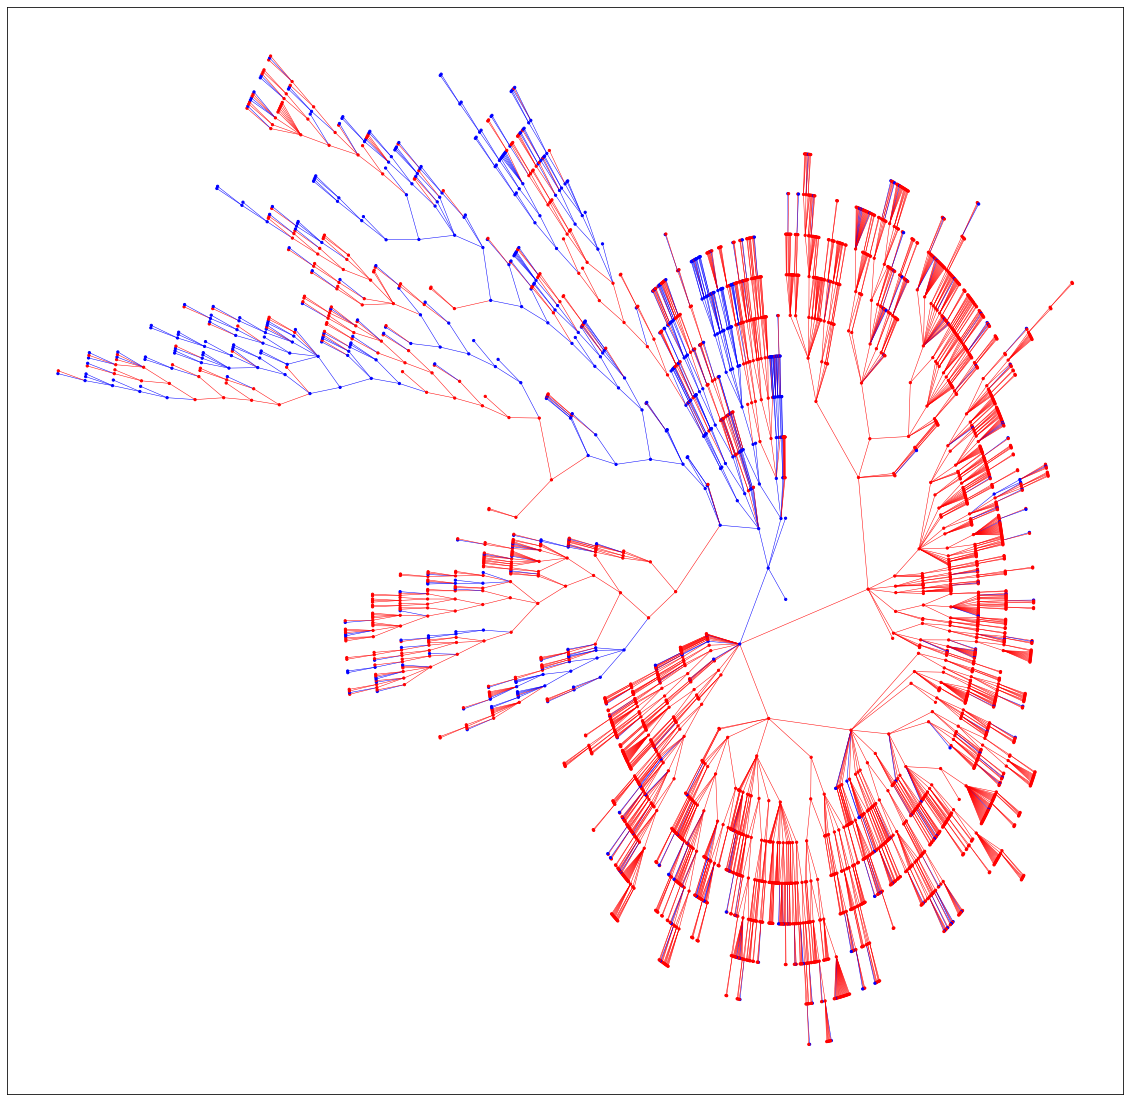

In [112]:
#labels needs to be a list with the same ordering as a loop over the tree nodes
#label = [some_label for n in tree.nodes() ]
labels = calc_interaction_on_taxonomy(cog1,cog2,dendrotree, verbose = True )
phylograph(dendrotree, labels)

In [113]:
check_interaction_pairs = False
if check_interaction_pairs == True:
    samples = 10
    for i in range(samples):
        r = coglink_df.sample(n = 1).iloc[0]
        print(r)
        cog1 = str(r.group1).replace("b",'').replace("'",'').strip()
        cog2 = str(r.group2).replace("b",'').replace("'",'').strip()
        labels = calc_interaction_on_taxonomy(cog1,cog2,dendrotree ,verbose = True)
        print(np.sum(labels))
        phylograph(dendrotree, labels)


In [114]:
#mapfam to matrow
humap_fam_map= { f:i for i,f in enumerate(humap_df.index)}
humap_profilemat = np.vstack(humap_df.mat)
print(humap_profilemat.shape)
string_fam_map = { f:i for i,f in enumerate(string_df.index)}
string_mat = np.vstack(string_df.mat)
print(string_mat.shape)

#train test split
Datasets = {}
for label,df,mapping,profilemat in [  ('string', stringPairs, string_fam_map ,string_mat ) , ('humap',humap_pairs, humap_fam_map , humap_profilemat) ]: 
    keys = set(mapping.keys())
    entry1 = [ f in keys for f in df.fam1]
    df = df.iloc[entry1]
    entry2 = [ f in keys for f in df.fam2]
    df = df.iloc[entry2]
    msk = np.random.rand(len(df)) < 0.8
    df_train = df.iloc[msk]
    df_test = df.iloc[~msk]
    Datasets[label]={'Train':df_train,'Test':df_test , 'mapping': mapping , 'mat':profilemat }
    print(label)
    print('train',len(df_train))
    print('test',len(df_test))

(3145, 10524)
(11788, 10524)
string
train 80823
test 20385
humap
train 6646
test 1647


In [115]:

def chunks(df, n):
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]
def generateXYchunk(explicit_profiles, goldstandardDF,fam_map,  nsamples=100, posi_percent = .5):
    #shuffle
    goldstandardDF = goldstandardDF.sample(frac=1)
    for chunkdf in chunks(goldstandardDF , int( nsamples*posi_percent)):
        #negatives drawn from the overall dataset
        X = np.hstack([ np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam1]) , np.vstack([profilemat[fam_map[f]] for f in chunkdf.fam2]) ] )
        Y = [1]* X.shape[0]
        neg1 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam1)
        neg2 = list(goldstandardDF.sample(n = int(nsamples*(1-posi_percent))).fam2)
        
        if len(neg1)>0:
            mixchunk = np.hstack([np.vstack([profilemat[fam_map[f]] for f in neg1]),np.vstack([profilemat[fam_map[f]] for f in neg2])])
            Y =np.hstack([[0]* mixchunk.shape[0] , Y])
            X= np.vstack([mixchunk,X])    
        #positive samples
        yield X, Y

In [116]:


def ROC_curve(y_data, label = None , title_add= ''):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for l in y_data:
        print(l)
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        fpr, tpr, _ = roc_curve(   y_pred_grd ,y_test)
        plt.plot(fpr, tpr, label=l + 'auc'+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    plt.title(title_add+'ROC curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_ROC.svg' )
    plt.show()
    
    
    plt.figure(figsize=(10,10))
    for l in y_data:
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        precision, recall, thresholds = precision_recall_curve( y_pred_grd, y_test)
        plt.plot( recall, precision , label= l )
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    
    plt.title(title_add+'PR curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_PR.svg' )
    plt.show()
    
def ROC_curve_single(y_test, y_pred_grd):
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, y_pred_grd)
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  y_test , y_pred_grd)
    plt.plot(precision, recall , label='single')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()


In [117]:
#try a vanilla deep NN
from keras.layers import Dense, Input
from keras.models import Sequential
import os
import tensorflow as tf
from keras.models import load_model

overwrite = True
train_dnn = False

if train_dnn == True:
    for dataset in Datasets:
        modelpath = './'+dataset+'_dropout_DNN.h5'
        callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir= modelpath+'.logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=modelpath)
        ]
        print(dataset)
        df_train = Datasets[label]['Train']
        fam_map = Datasets[label]['mapping']
        profilemat = Datasets[label]['mat']
        if os.path.exists(modelpath) and overwrite == False:
            model = load_model(modelpath)
        else:
            model = Sequential()
            model.add(Dense(units=100, activation='sigmoid', input_dim=profilemat.shape[1]*2))
            model.add(tf.keras.layers.Dropout( .2 , seed=42 ))
            model.add(Dense(units=30, activation='sigmoid' ) )
            model.add(Dense(units=1, activation='sigmoid' ) )
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        generator = generateXYchunk(profilemat, df_train, fam_map , posi_percent= .5 , nsamples = 50 )
        sample = next(generator)
        model.fit(itertools.cycle(generator) , steps_per_epoch = 300 , epochs = 50, callbacks=callbacks)
        # Save the model
        model.save(modelpath)

In [118]:

from scipy.spatial.distance import euclidean , hamming, jaccard

#use jaccard distance AUC to tune dataset cutoffs for string

visualize = False    
if visualize == True:
    dataset = Datasets['string']
    label = 'string'

    df_test = Datasets[label]['Test']
    fam_map = Datasets[label]['mapping']
    profilemat = Datasets[label]['mat']
    ydata =  {}

    df_test.hist()

    plt.show()

    threshes = [ 1000 , 1500 , 2000 , 3000]
    dataset_len =[]
    xaxis =[]
    for thresh in threshes:
        func, name =  (jaccard,'Jaccard')
        print(name)

        sub = df_test[df_test.score>thresh]
        dataset_len.append(len(sub))
        xaxis.append(thresh)

        generator = generateXYchunk(profilemat, sub, fam_map , posi_percent= .5 , nsamples = 50 )
        #test all the easy metrics
        ypreds = []
        ytruth = []
        for X,y in generator:
            #distances
            x1 = X[:,0:int(X.shape[1]/2)]
            x2 = X[:,int(X.shape[1]/2):]
            predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
            ypreds.append(predictions)
            ytruth.append(y)
        ytest= np.hstack(ytruth)
        ypred = np.hstack(ypreds)
        ydata[name+str(thresh)] = { 'Ypred': ypred , 'Ytrue':ytest}
    ROC_curve(ydata , label = str(thresh ) + 'string' , title_add='combined score ')
    plt.show()
    plt.plot(xaxis ,dataset_len)
    plt.show()


    threshes = [ 100 , 200 , 300, 500, 600 ,700, 800, 900 ]
    for metric in ['database', 'coexpression' , 'textmining' , 'experimental' ]:
        print(metric)
        ydata =  {}

        dataset_len =[]
        xaxis =[]
        for thresh in threshes:
            func, name =  (jaccard,'Jaccard')
            print(name)
            sub = df_test[df_test[metric] > thresh]
            if len(sub) > 0:

                dataset_len.append(len(sub))
                xaxis.append(thresh)
                generator = generateXYchunk(profilemat, sub, fam_map , posi_percent= .5 , nsamples = 50 )
                #test all the easy metrics
                ypreds = []
                ytruth = []
                for X,y in generator:
                    #distances
                    x1 = X[:,0:int(X.shape[1]/2)]
                    x2 = X[:,int(X.shape[1]/2):]
                    predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
                    ypreds.append(predictions)
                    ytruth.append(y)
                ytest= np.hstack(ytruth)
                ypred = np.hstack(ypreds)
                ydata[name+str(thresh)] = { 'Ypred': ypred , 'Ytrue':ytest}

        ROC_curve(ydata , label = str(thresh ) + 'string' ,  title_add=metric + ' ')
        plt.show()

        plt.plot(xaxis ,dataset_len)
        plt.show()



    threshes = [ 5,10, 50, 100 , 200 , 300, 500, 600 ,700, 800, 900 ]

    print(metric)
    ydata =  {}

    dataset_len =[]
    xaxis =[]
    for thresh in threshes:
        func, name =  (jaccard,'Jaccard')
        print(name)

        sub = df_test[df_test.count1 > thresh]
        sub = sub[sub.count2 > thresh]

        if len(sub) > 50:
            dataset_len.append(len(sub))
            xaxis.append(thresh)

            generator = generateXYchunk(profilemat, sub, fam_map , posi_percent= .5 , nsamples = 50 )
            #test all the easy metrics
            ypreds = []
            ytruth = []
            for X,y in generator:
                #distances
                x1 = X[:,0:int(X.shape[1]/2)]
                x2 = X[:,int(X.shape[1]/2):]
                predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
                ypreds.append(predictions)
                ytruth.append(y)

            ytest= np.hstack(ytruth)
            ypred = np.hstack(ypreds)
            ydata[name+str(thresh)] = { 'Ypred': ypred , 'Ytrue':ytest}
    ROC_curve(ydata , label = str(thresh ) + 'string' , title_add='interaction count ' )
    plt.show()

    plt.plot(xaxis ,dataset_len)
    plt.title('testing dataset size' )
    plt.show()



In [119]:
#normal distance metrics to try

from scipy.spatial.distance import euclidean , hamming, jaccard
from sklearn.covariance import empirical_covariance
from scipy.stats import pearsonr
from keract import get_activations
def pearsonR(v1,v2):
        return -pearsonr(v1,v2)[0]

visualize = False    
if visualize == True:
    for label in Datasets:
        print(label)
        df_test = Datasets[label]['Test']
        fam_map = Datasets[label]['mapping']
        profilemat = Datasets[label]['mat']
        ydata =  {}

        for func, name in [ (euclidean, 'Euclidean' ), (hamming,'Hamming') , (jaccard,'Jaccard') , (pearsonR,'Pearson') ]:
            print(name)
            generator = generateXYchunk(profilemat, df_test, fam_map , posi_percent= .5 , nsamples = 50 )
            #test all the easy metrics
            ypreds = []
            ytruth = []
            for X,y in generator:
                #distances
                x1 = X[:,0:int(X.shape[1]/2)]
                x2 = X[:,int(X.shape[1]/2):]
                predictions = np.array([ -func(x1[r,:],x2[r,:] ) for r in range(x1.shape[0]) ])
                ypreds.append(predictions)
                ytruth.append(y)
            ytest= np.hstack(ytruth)
            ypred = np.hstack(ypreds)
            ydata[name] = { 'Ypred': ypred , 'Ytrue':ytest} 
        #get DNN values
        print('DNN')
        generator = generateXYchunk(profilemat, df_test, fam_map , posi_percent= .5 , nsamples = 50 )
        mats = [(x,y) for x,y in generator ]
        y_test = np.hstack([y for x,y in mats])
        modelpath = './'+label+'_dropout_DNN.h5'
        if os.path.exists(modelpath):
            model = load_model(modelpath)


        ypred = np.vstack([ model.predict(x) for x,y in mats])


        #activations = [ get_activations(model, x , auto_compile=True) for x,y in mats] 
        #activations = activations[list(activations.keys())[0]]
        #print( activations.shape)
        #n_samples = activations.shape[0]
        #activations = np.sum(activations,axis =0)/n_samples
        #representations = np.sum(X_test, axis = 0)

        #print(activations.shape)

        #np.save(modelpath + 'activation.np' , activations)
        #np.save(modelpath + 'representation.np', representations)

        ydata['DNN'] ={ 'Ypred': ypred , 'Ytrue':ytest}
        #plot ROC
        print(ydata)
        ROC_curve(ydata , label = label)
        plt.show()


In [120]:
#######################being the graph NN part of the paper #####################################

In [121]:
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import ChebConv
from torch_geometric.nn import  to_hetero
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData ,InMemoryDataset
import copy
import time
import pickle
import random
#create graphs on the fly to represent pairs of profiles
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [122]:
nodes = set([ n.name for n in p.tree.traverse() ])
dendrotree_nodes = set([str(n.taxon.label) if n.taxon else '-1' for n in dendrotree.nodes()] )

In [123]:
print(len(nodes))
print(len(dendrotree_nodes))
print(len(nodes.intersection(dendrotree_nodes)))

3508
3508
3508


In [124]:
profile_mapper = { n.name:i for i,n in enumerate(p.tree.traverse()) }

In [125]:
profile_mapper = { (n.taxon.label if n.taxon else '-1'):n.matrow for n in  dendrotree.nodes() }

In [126]:
def tree2Single_sparse_graph_updown(tree):
    N = len(tree.nodes())
    #mimic the fitch algo
    #propagate up and down in separate graphs
    index_up = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    index_down = np.vstack([ [c.matrow, n.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    connectmat_up = scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_down = scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_up[index_up[:,0],index_up[:,1]] = 1 
    connectmat_down[index_down[:,0],index_down[:,1]] = 1 
    diag = [[n,n] for n in range(N)]
    connectmat_diag=scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_diag[diag,diag] = 1 
    ntime = np.array([ n.distance_from_root() for n in tree.nodes()])
    mtime = np.amax(ntime)
    ntime/=mtime
    levels = np.array([ n.level() for n in tree.nodes() ] , dtype='double')
    levels /= np.amax(levels)
    Norm_nchild= np.array( [ len(n.child_nodes()) for n in tree.nodes() ] ,dtype='double' )
    mchild =np.amax(Norm_nchild)
    Norm_nchild/=mchild 
    Norm_nsister= np.array( [ len(n.sister_nodes()) for n in tree.nodes() ] ,dtype='double' )
    msis =np.amax(Norm_nsister)
    Norm_nsister/=msis    
    template_features = np.stack([ntime ,  Norm_nchild , Norm_nsister ]).T    
    return connectmat_up, connectmat_down, connectmat_diag, template_features

In [127]:

def getmrca(treein,taxset):
    
    tree = copy.deepcopy(treein)
    n = tree.mrca(taxon_labels=taxset)
    if n is not None:
        subtree = dendropy.Tree(seed_node=n)
        taxset = set([ t.taxon.label if t.taxon else '-1'  for t in subtree.nodes()])
        matrows = [ t.matrow for t in treein.nodes() if t.taxon and t.taxon.label in taxset]
        return taxset, matrows , n
    else: 
        return None, None, None

In [128]:
def sparse2pairs(sparsemat, matrows = None):
    if matrows :
        sparsemat = sparsemat[matrows,:]
        sparsemat = sparsemat[:,matrows]
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 1)	1.0
  (9, 1)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 2)	1.0
  (13, 2)	1.0
  (14, 2)	1.0
  (15, 2)	1.0
  (16, 2)	1.0
  (17, 3)	1.0
  (18, 3)	1.0
  (19, 3)	1.0
  (20, 3)	1.0
  (21, 3)	1.0
  (22, 3)	1.0
  (23, 3)	1.0
  (24, 3)	1.0
  :	:
  (3483, 91)	1.0
  (3484, 91)	1.0
  (3485, 91)	1.0
  (3486, 91)	1.0
  (3487, 91)	1.0
  (3488, 91)	1.0
  (3489, 91)	1.0
  (3490, 91)	1.0
  (3491, 91)	1.0
  (3492, 91)	1.0
  (3493, 91)	1.0
  (3494, 91)	1.0
  (3495, 91)	1.0
  (3496, 91)	1.0
  (3497, 91)	1.0
  (3498, 91)	1.0
  (3499, 91)	1.0
  (3500, 91)	1.0
  (3501, 91)	1.0
  (3502, 91)	1.0
  (3503, 91)	1.0
  (3504, 91)	1.0
  (3505, 91)	1.0
  (3506, 91)	1.0
  (3507, 91)	1.0
nsectors 92


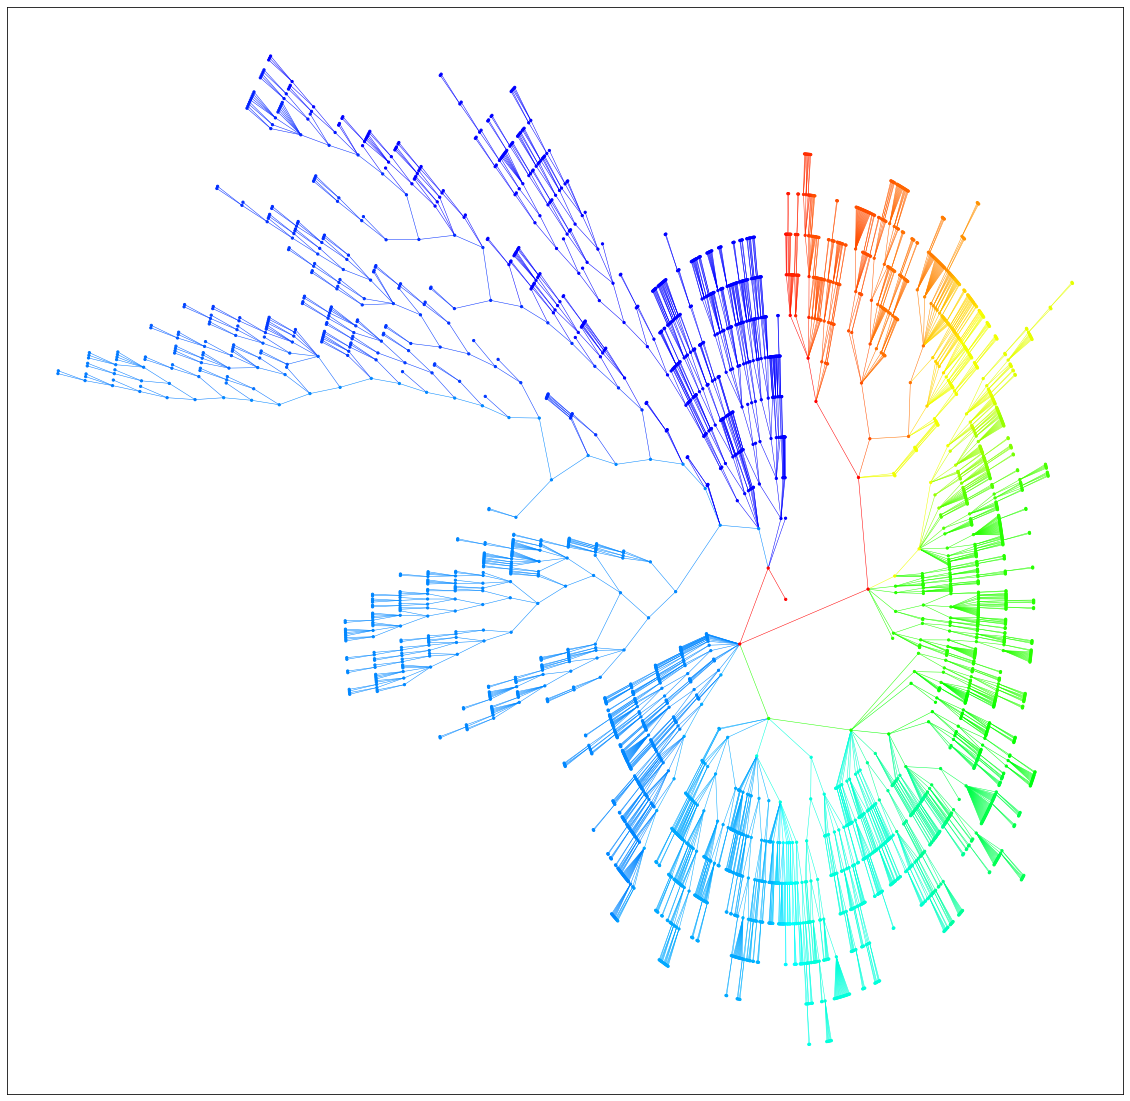

In [129]:
#tree sector based aggregation
#label sectors

def process_node_down(node, sector = 0, breakpt = 10 , total = 0 ):
    node.sector = sector
    if sector == 0 :
        global count
        count = 0
    total += len(node.child_nodes())
    for i,child in enumerate(node.child_nodes()):
        if total > breakpt:
            if len(child.child_nodes())>0:
                #new sector w new total
                count+=1
                process_node_down(child, count , total = 0 , breakpt = breakpt)
            else:
                #leaf
                process_node_down(child, count , total = 0 , breakpt = breakpt)
        else:
            process_node_down(child, count , total = total , breakpt = breakpt)

    
def get_sectors(tree, breakpt = 20):
    process_node_down( tree.seed_node , sector = 0, breakpt = breakpt )
    row = [n.matrow for n in tree.nodes()]
    col = [n.sector for n in tree.nodes()]
    data = np.ones((len(row)))
    sectormat = scipy.sparse.csc_matrix( (data,(row,col)) )
    return sectormat

for i,l in enumerate(dendrotree.nodes()):
    l.sum_lengths = None
for i,l in enumerate(dendrotree.leaf_nodes()):
    l.sum_lengths = 1
sectormat = get_sectors(dendrotree, breakpt = 60 )
print(sectormat)
labels = [n.sector for n in dendrotree.nodes()]
print('nsectors' , len(set(labels)))
phylograph( dendrotree, labels )

In [130]:
def create_data_updown( tree, coglinkdf, profiles , taxindex , posi_percent = .5 ,  q = None , iolock= None,  verbose = False, loop= True ):
        #upward and downward connected phylo nodes
        connectmat_up, connectmat_down, connectmat_diag, template_features = tree2Single_sparse_graph_updown(tree)
        
        #sector based aggregation
        sectormat = get_sectors(tree, breakpt = 15 )
        num_total_nodes = template_features.shape[0]
        if iolock:
            with iolock:
                print('dataset size' , len(coglinkdf))
        else:
            print('dataset size' , len(coglinkdf))
        
        N = len(tree.nodes())
        Nsectors = sectormat.shape[1]
        allfams = list(set(coglinkdf.fam1.unique()).union( set(coglinkdf.fam2.unique() ) ))
        leafset = set([n.taxon.label for n in tree.leaf_nodes()])
        
        while True:
            toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
            if verbose == True:
                print('posi/nega',toss)
            if toss == 0:
                fam1 = random.choice(allfams)
                fam2 = fam1
                while fam1 == fam2:
                    fam2 = random.choice(allfams)
                labels = np.zeros((template_features.shape[0],))
            else:
                #positive sample
                dfline = coglinkdf.sample(n=1, random_state = random.randint(1,1000)).iloc[0]
                cog1= str(dfline.group1).replace("b",'').replace("'",'').strip()
                cog2= str(dfline.group2).replace("b",'').replace("'",'').strip()
                fam1 = dfline.fam1
                fam2 = dfline.fam2
                labels = calc_interaction_on_taxonomy(cog1,cog2,tree)
            nodefeatures = []
            presences= []
            #find profile nameset
            for i,tp in enumerate([profiles[fam1]['tree'], profiles[fam2]['tree']]):    
                profilefeatures = np.zeros((template_features.shape[0],3) )
                #find on which nodes the events happened
                losses = [ n.name  for n in tp.traverse() if n.lost ]
                dupl = [ n.name  for n in tp.traverse() if n.dupl ]
                presence = [ n.name  for n in tp.traverse() if n.nbr_genes > 0   ]
                presences.append(presence)
                losses = [taxindex[n] for n in losses] 
                dupl = [taxindex[n] for n in dupl]
                presence = [taxindex[n] for n in presence]
                profilefeatures[losses, 0] = 1
                profilefeatures[dupl, 1] = 1
                profilefeatures[presence, 2] = 1
                nodefeatures.append(profilefeatures)
            nodeset = set(presences[0]).union(set(presences[1]))
            if len(nodeset)> 10:
                skip = False
                try:
                    taxset,matrows,n = getmrca(tree,leafset.intersection(nodeset))
                    if taxset == None:
                        skip = True
                except ValueError:
                    #no species overlap
                    skip = True

                if skip == False:
                    
                    #pare down labels
                    labels = labels[matrows]
                    
                    if verbose == True:
                        print('features',nodefeatures)
                        print( 'labels' , labels)
                        
                    neglabels = np.ones(labels.shape)
                    neglabels = neglabels - labels
                    labels = np.vstack([labels,neglabels]).T
                    
                    #filter sectormat
                    subsectors = sectormat[matrows,:]
                    #use only connected sectors
                    i=np.where(subsectors.sum(axis=0)!=0)[1]
                    subsectors = subsectors[: , i]
                    Nsectors = subsectors.shape[1]
                    subsectors = sparse2pairs(subsectors)
                    #connect god node to sectors
                    
                    suboverview = scipy.sparse.lil_matrix((Nsectors , 2 ) )
                    suboverview[:,0] = 1
                    
                    suboverview_rev = suboverview.T
                    suboverview_rev = sparse2pairs(suboverview_rev)
                    suboverview = sparse2pairs(suboverview)
                    
                    #phylonode connections
                    subconnect_up = sparse2pairs(connectmat_up, matrows)
                    subconnect_down = sparse2pairs(connectmat_down, matrows)
                    subdiag = sparse2pairs(connectmat_diag, matrows)
                    
                    
                    
                    #profile features
                    nodefeatures=np.hstack(nodefeatures)
                    
                    sub_template_features= template_features[matrows,:]
                    sub_node_features= nodefeatures[matrows,:]
                    sub_node_features = np.hstack([sub_template_features , sub_node_features])
                    
                    godlabel = np.ones((1,1))*toss
                    godlabel = np.hstack([np.ones((1,1))-godlabel, godlabel])
                    
                    
                    sectorlabel = np.ones((Nsectors,1))*toss
                    sectorlabel = np.hstack([np.ones((Nsectors,1))-sectorlabel, sectorlabel])

                    data = HeteroData()   
                    
                    data['phylonodes_up'].x = torch.tensor(sub_node_features, dtype=torch.double )
                    data['phylonodes_down'].x = torch.tensor(sub_node_features, dtype=torch.double )
                    data['sectornode'].x =torch.tensor(  np.zeros(( Nsectors ,1))  ,  dtype=torch.double )
                    data['godnode'].x =torch.tensor(  np.zeros((1,1))  ,  dtype=torch.double )

                    #up down fitch net
                    data['phylonodes_up', 'phylolink_up', 'phylonodes_up'].edge_index = torch.tensor(subconnect_up ,  dtype=torch.long )
                    data['phylonodes_down', 'phylolink_down', 'phylonodes_down'].edge_index = torch.tensor(subconnect_down ,  dtype=torch.long )             
                    data['phylonodes_up', 'phylolink_up_down', 'phylonodes_down'].edge_index = torch.tensor( subdiag ,  dtype=torch.long )
                    data['phylonodes_down', 'phylolink_down_up', 'phylonodes_up'].edge_index = torch.tensor( subdiag ,  dtype=torch.long )

                    #pooling connections
                    data['phylonodes_down', 'informs', 'sectornode'].edge_index = torch.tensor(subsectors,  dtype=torch.long )
                    data['phylonodes_up', 'informs', 'sectornode'].edge_index = torch.tensor(subsectors ,  dtype=torch.long )
                    
                    #final decision node
                    data['sectornode', 'informs', 'godnode'].edge_index = torch.tensor(suboverview,  dtype=torch.long )
                    data['godnode', 'informs', 'sectornode'].edge_index = torch.tensor(suboverview_rev,  dtype=torch.long )

                    #add 2 label classes                
                    data['phylonodes_up'].y =torch.tensor(labels  ,  dtype=torch.long )
                    data['phylonodes_down'].y =torch.tensor(labels  ,  dtype=torch.long )
                    data['sectornode'].y =torch.tensor( sectorlabel  ,  dtype=torch.long )
                    data['godnode'].y =torch.tensor( godlabel  ,  dtype=torch.long )

                    #data = T.AddSelfLoops()(data)
                    data = T.NormalizeFeatures()(data)
                    if q:
                        q.put(data)
                    else:
                        yield data


In [ ]:
gen = create_data_updown( dendrotree, Datasets['string']['Train']  , stringprofiles , profile_mapper, .5  , verbose = False  )
print(next(gen))

In [64]:
traindata_gen = True
trainsample= 10000

#create training set using the generator on training samples
reload = True
if traindata_gen == True:
    if reload == True:
        with open('trainingset_v3.pkl' , 'rb')as trainout:
            samples = pickle.loads(trainout.read())
    else:
        print('newsamples')
        samples = []
    if traindata_gen == True:
        gen = create_data_updown( dendrotree, Datasets['string']['Train']  , stringprofiles , profile_mapper, .5  , verbose = False  )
        for i , data in enumerate( gen ):
            if i < 5:
                print(data)
                print(data['godnode'].y)
            if i % 100 ==0:
                print(i, len(samples))
                with open('trainingset_v3.pkl' , 'wb')as trainout:
                    trainout.write(pickle.dumps(samples))
            samples.append(data)
            
            
            

dataset size 80907
HeteroData(
  phylonodes_up={
    x=[3507, 9],
    y=[3507, 2]
  },
  phylonodes_down={
    x=[3507, 9],
    y=[3507, 2]
  },
  sectornode={
    x=[269, 1],
    y=[269, 2]
  },
  godnode={
    x=[1, 1],
    y=[1, 2]
  },
  (phylonodes_up, phylolink_up, phylonodes_up)={ edge_index=[2, 3506] },
  (phylonodes_down, phylolink_down, phylonodes_down)={ edge_index=[2, 3506] },
  (phylonodes_up, phylolink_up_down, phylonodes_down)={ edge_index=[2, 3507] },
  (phylonodes_down, phylolink_down_up, phylonodes_up)={ edge_index=[2, 3507] },
  (phylonodes_down, informs, sectornode)={ edge_index=[2, 3507] },
  (phylonodes_up, informs, sectornode)={ edge_index=[2, 3507] },
  (sectornode, informs, godnode)={ edge_index=[2, 269] },
  (godnode, informs, sectornode)={ edge_index=[2, 269] }
)
tensor([[1, 0]])
0 2000
HeteroData(
  phylonodes_up={
    x=[3507, 9],
    y=[3507, 2]
  },
  phylonodes_down={
    x=[3507, 9],
    y=[3507, 2]
  },
  sectornode={
    x=[269, 1],
    y=[269, 2]
  }

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/5736951/ipykernel_270023/882984659.py", line 15, in <module>
    for i , data in enumerate( gen ):
  File "/tmp/5736951/ipykernel_270023/2623716314.py", line 36, in create_data_updown
    labels = calc_interaction_on_taxonomy(cog1,cog2,tree)
  File "/tmp/5736951/ipykernel_270023/2993289.py", line 16, in calc_interaction_on_taxonomy
    checklinks = [ bfilter( spec) for spec in coglinks_species ]
  File "/tmp/5736951/ipykernel_270023/2993289.py", line 16, in <listcomp>
    checklinks = [ bfilter( spec) for spec in coglinks_species ]
  File "/tmp/5736951/ipykernel_270023/795882484.py", line 3, in check_filters
    if element in f[0][0]:
  File "/scratch/dmoi/condaenvs/ML2/lib/python3.9/site-packages/bloom_filter2/bloom_filter.py", line 545, in __contains__
    for bit

TypeError: object of type 'NoneType' has no len()

In [65]:
#create testing set using the testing set dataframe
testdata_gen = True
testsample= 2000
NCORE = 20
reload = True
if testdata_gen == True:
    if reload == True:
        with open('testgset_v3.pkl' , 'rb')as trainout:
            samples = pickle.loads(trainout.read())
    else:
        print('newsamples')
        samples = []
    if testdata_gen == True:
        gen = create_data_updown( dendrotree, Datasets['string']['Test']  , stringprofiles , profile_mapper, .5  )
        for i , data in enumerate( gen ):
            if i % 100 ==0:
                print(i, len(samples))
                with open('testgset_v3.pkl' , 'wb')as trainout:
                    trainout.write(pickle.dumps(samples))
            samples.append(data)


newsamples
dataset size 20301
ERROR! Session/line number was not unique in database. History logging moved to new session 1431
0 0
100 100
200 200
300 300
400 400
500 500
600 600


KeyboardInterrupt: 

In [137]:
with open('trainingset_v3.pkl' , 'rb')as trainout:
    trainingdata = pickle.loads(trainout.read())
with open('testgset_v3.pkl' , 'rb')as trainout:
    testingdata = pickle.loads(trainout.read())

In [138]:
data = trainingdata[10]
print(data)


HeteroData(
  phylonodes_up={
    x=[3507, 9],
    y=[3507, 2]
  },
  phylonodes_down={
    x=[3507, 9],
    y=[3507, 2]
  },
  sectornode={
    x=[269, 1],
    y=[269, 2]
  },
  godnode={
    x=[1, 1],
    y=[1, 2]
  },
  (phylonodes_up, phylolink_up, phylonodes_up)={ edge_index=[2, 3506] },
  (phylonodes_down, phylolink_down, phylonodes_down)={ edge_index=[2, 3506] },
  (phylonodes_up, phylolink_up_down, phylonodes_down)={ edge_index=[2, 3507] },
  (phylonodes_down, phylolink_down_up, phylonodes_up)={ edge_index=[2, 3507] },
  (phylonodes_down, informs, sectornode)={ edge_index=[2, 3507] },
  (phylonodes_up, informs, sectornode)={ edge_index=[2, 3507] },
  (sectornode, informs, godnode)={ edge_index=[2, 269] },
  (godnode, informs, sectornode)={ edge_index=[2, 269] }
)


In [141]:
from torch_geometric.nn import HeteroConv, SAGPooling , SAGEConv, Linear  ,HeteroLinear , GraphConv,ResGatedGraphConv , GATv2Conv , TransformerConv , MFConv , FiLMConv

    
import torch_geometric.transforms as T

class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        #self.pools = torch.nn.ModuleList()
        self.lins =  torch.nn.ModuleList()
        self.lins2 =  torch.nn.ModuleList()
        
        for i in range(num_layers):
            conv = HeteroConv({
                
                ('phylonodes_up', 'phylolink_up', 'phylonodes_up'):MFConv((-1,-1), hidden_channels ),
                ('phylonodes_down', 'phylolink_down', 'phylonodes_down'):MFConv((-1,-1), hidden_channels ),
                ('phylonodes_down', 'phylolink_down_up', 'phylonodes_up'):MFConv((-1,-1), hidden_channels ),
                ('phylonodes_up', 'phylolink_up_down', 'phylonodes_down'):MFConv((-1,-1), hidden_channels ),
                
                ( 'phylonodes_down', 'informs', 'sectornode'):FiLMConv((-1,-1), hidden_channels ),
                ( 'phylonodes_up', 'informs', 'sectornode'):FiLMConv((-1,-1), hidden_channels ),

                ('godnode', 'informs', 'sectornode'):TransformerConv((-1,-1), hidden_channels ),
                ('sectornode', 'informs', 'godnode'):TransformerConv((-1,-1), hidden_channels )
            
            } , aggr='sum')
            
            self.convs.append(conv)

            for vectype in  ['phylonodes_up', 'phylonodes_down' , 'sectornode' , 'godnode' ]:
                lin1 = Linear(-1 , int( hidden_channels/(i+1)))
                self.lins.append( lin1 )
        
        for vectype in ['phylonodes_up', 'phylonodes_down' , 'sectornode' , 'godnode' ]:
            lin2 = Linear(-1 , out_channels)
            self.lins2.append( lin2 ) 

    
    def forward(self, x_dict, edge_index_dict):
        for i,conv in enumerate(self.convs):
            x_dict = conv(x_dict , edge_index_dict)
            x_dict = {key: F.dropout(x , p = .10 , training = self.training ) for key, x in x_dict.items()}
            x_dict = {key: x.relu() for key, x in x_dict.items()}
            #x_dict = lin(x_dict , edge_index_dict)
            count = 0 
            for key, x in x_dict.items():
                x_dict[key] =  self.lins[4*i + count](x)
                count +=1
        count = 0 
        for key, x in x_dict.items():
            x_dict[key] =  self.lins2[count](x)
            count +=1
        
        return {key: F.tanh(x) for key, x in x_dict.items()}
        #return x_dict

model = HeteroGCN(hidden_channels=100, out_channels=2, num_layers=5)
model = model.double()


In [142]:
with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict , data.edge_index_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
#optimizer=torch.optim.RMSprop(model.parameters(), lr=0.00001, alpha=0.99, eps=0, weight_decay=0, momentum=0, centered=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

IndexError: index 16 is out of range

In [75]:
import time
#model = model.to(device)
trainloader = DataLoader( trainingdata , batch_size = 5 , shuffle=True)

testloader = DataLoader(testingdata , batch_size = 10 )

#penalize false negatives more
#weights = torch.tensor([.99,.01],  dtype=torch.double )
#weights = weights.to(device)
print('start training')


import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = model.to(device)
    for epoch in range(2000):
        model.train()
        losses1=[]
        losses2 =[]
        losses3 =[]
        for i,data in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x_dict ,data.edge_index_dict)
            loss1 =  F.mse_loss(out['phylonodes_up'].double(), data['phylonodes_up'].y.double())
            loss2 =  F.mse_loss(out['phylonodes_down'].double(), data['phylonodes_down'].y.double())
            loss3 =  F.mse_loss(out['godnode'].double(), data['godnode'].y.double())
            loss4 =  F.mse_loss(out['sectornode'].double(), data['sectornode'].y.double())

            loss =  loss3 + loss2 + loss4

            loss.backward()
            optimizer.step()
            losses3.append(float(loss3.to('cpu')))
            losses2.append(float(loss2.to('cpu')))
            losses1.append(float(loss4.to('cpu')))
        print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3)) 
        #scheduler.step( np.mean(losses3) )

        model.eval()

        aucs = []
        aucsn = []
        aucss = []

        for i,testdata in enumerate(testloader):
            testdata = testdata.to(device)
            pred = model(testdata.x_dict ,testdata.edge_index_dict)
            pred = {idx:x.to('cpu') for idx,x in pred.items()}
            truth = testdata['godnode']['y'][:,0].to('cpu').detach().numpy()
            predy =  pred['godnode'][:,0].to('cpu').detach().numpy()
            fpr, tpr, _ = roc_curve(  truth  ,predy )
            aucs.append(auc(fpr, tpr))
            truth = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
            predy =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()
            fpr, tpr, _ = roc_curve(  truth  ,predy )
            aucsn.append(auc(fpr, tpr))

            truth = testdata['sectornode']['y'][:,0].to('cpu').detach().numpy()
            predy =  pred['sectornode'][:,0].to('cpu').detach().numpy()
            fpr, tpr, _ = roc_curve(  truth  ,predy )
            aucss.append(auc(fpr, tpr))

        meanauc = np.mean(aucs)
        print('auc',meanauc)
        meanauc = np.mean(aucsn)
        print('auc_n',meanauc)
        meanauc = np.mean(aucss)
        print('auc_s',meanauc)


start training
losses 0.2571554743652349 0.10239486631683851 0.2548168480033206
auc 0.4546388888888888
auc_n 0.7277454136222384
auc_s 0.5517385908538138
losses 0.25138061797580225 0.09884016148056278 0.2517367092872591
auc 0.4432480158730158
auc_n 0.730650075802407
auc_s 0.5110583794586703
losses 0.2516794024792782 0.10058084736636506 0.25114602858929214
auc 0.4966765873015873
auc_n 0.7232291540324193
auc_s 0.48491210403508334
losses 0.24770032164622713 0.09583847267031255 0.2515877876482191
auc 0.5048055555555556
auc_n 0.7351612322389501
auc_s 0.5374168215257348
losses 0.24692561231012097 0.0965096063270368 0.251168482703598
auc 0.4980198412698413
auc_n 0.732049929631998
auc_s 0.5423426546958947
losses 0.24642143504353128 0.09727267866291076 0.2509438884910119
auc 0.5028571428571429
auc_n 0.7437853376328393
auc_s 0.5431909092365195
losses 0.24733838112183018 0.09495942905273783 0.2510830911253721
auc 0.47029001322751324
auc_n 0.7452481134938079
auc_s 0.5385427699665242
losses 0.376835

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), './graphnet.torch')


In [ ]:
model.eval()
truths = []
preds = []

truths_n = []
preds_n = []

testloader = DataLoader(testingdata , batch_size = 10 )
for i,testdata in enumerate(testloader):
    testdata = testdata.to(device)
    pred = model(testdata.x_dict ,testdata.edge_index_dict)
    pred = {idx:x.to('cpu') for idx,x in pred.items()}
    
    truth = testdata['godnode']['y'][:,0].to('cpu').detach().numpy()
    predy =  pred['godnode'][:,0].to('cpu').detach().numpy()
    truths.append(truth)
    preds.append(predy)
    
    truth_n = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
    pred_n =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()
    
    truths_n.append(truth_n)
    preds_n.append(pred_n)
    
truth = np.hstack(truths)
predy = np.hstack(preds)

print(predy)
print(truth)
ROC_curve_single( truth , predy)
fpr, tpr, _ = roc_curve(  truth  ,predy )
auc_gn = auc(fpr, tpr)

truth_n = np.hstack(truths_n)
predy_n = np.hstack(preds_n)

ROC_curve_single( truth_n, predy_n)
fpr, tpr, _ = roc_curve(  truth  ,predy )
auc_n = auc(fpr, tpr)

